In [1]:
# Cell 0: Versions & CPU only (PyTorch)
import os, random, numpy as np
os.environ["CUDA_VISIBLE_DEVICES"] = ""  # cưỡng bức dùng CPU

import torch
torch.backends.mps.is_available()  # Mac M1 có thể hiện True (Metal), ta vẫn force CPU ở dưới

SEED = 1337
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
torch.set_num_threads(4)  # giúp CPU ổn định
DEVICE = torch.device("cpu")
DEVICE


device(type='cpu')

In [2]:
# Cell 1: Load & sort
import pandas as pd

PATH = "/Users/dophi/Desktop/btl_doan2/crypto-prediction/data/processed/BTCUSDT_1d_features.csv"  
df = pd.read_csv(PATH)
df["datetime"] = pd.to_datetime(df["datetime"])
df = df.sort_values("datetime").reset_index(drop=True)

df.tail(3), df.shape


(                datetime      close       high        low       volume  \
 1068 2025-11-06 07:00:00  101346.04  104200.00  100300.95  25814.62139   
 1069 2025-11-07 07:00:00  103339.08  104096.36   99260.86  32059.50942   
 1070 2025-11-08 07:00:00  102051.29  103406.22  101715.76   7237.93760   
 
                MA_7        MA_25     RSI_14  price_change_pct  \
 1068  106222.607143  109280.2252  34.610409         -2.444160   
 1069  105327.045714  108807.1484  39.144808          1.966569   
 1070  104177.501429  108368.0744  37.342899         -1.246179   
 
       volume_change_pct  hl_range_pct  
 1068         -23.577392      3.847264  
 1069          24.191283      4.679256  
 1070         -77.423430      1.656481  ,
 (1071, 11))

In [3]:
# Cell 2: Chia 70/15/15 theo thứ tự thời gian
n = len(df)
n_train = int(n * 0.70)
n_val   = int(n * 0.15)
n_test  = n - n_train - n_val

train_df = df.iloc[:n_train].copy()
val_df   = df.iloc[n_train:n_train+n_val].copy()
test_df  = df.iloc[n_train+n_val:].copy()

(len(train_df), len(val_df), len(test_df), df["datetime"].min(), df["datetime"].max())


(749,
 160,
 162,
 Timestamp('2022-12-04 07:00:00'),
 Timestamp('2025-11-08 07:00:00'))

In [4]:
# Cell 3: Chọn cột features & target
FEATURE_COLS = [
    "close","high","low","volume","MA_7","MA_25","RSI_14",
    "price_change_pct","volume_change_pct","hl_range_pct"
]
TARGET_COL = "close"

assert all(c in df.columns for c in FEATURE_COLS+[TARGET_COL])


In [5]:
# Cell 4: MinMaxScaler fit trên train, transform val/test
from sklearn.preprocessing import MinMaxScaler

scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_train = scaler_X.fit_transform(train_df[FEATURE_COLS].values)
y_train = scaler_y.fit_transform(train_df[[TARGET_COL]].values)

X_val   = scaler_X.transform(val_df[FEATURE_COLS].values)
y_val   = scaler_y.transform(val_df[[TARGET_COL]].values)

X_test  = scaler_X.transform(test_df[FEATURE_COLS].values)
y_test  = scaler_y.transform(test_df[[TARGET_COL]].values)

In [6]:
# Cell 5: Hàm tạo sequences
import numpy as np

def make_sequences(X, y, seq_len: int):
    Xs, ys = [], []
    for i in range(seq_len, len(X)):
        Xs.append(X[i-seq_len:i])   # (seq_len, n_features)
        ys.append(y[i])             # (1,)
    return np.array(Xs, dtype=np.float32), np.array(ys, dtype=np.float32)

# Ví dụ thử seq_len=60 để xem shape
Xtr60, ytr60 = make_sequences(X_train, y_train, 60)
Xtr60.shape, ytr60.shape


((689, 60, 10), (689, 1))

In [ ]:
# Cell 6: Mô hình
import torch
import torch.nn as nn

class LSTMRegressor(nn.Module):
    def __init__(self, n_features, hidden_size=128, num_layers=2, dropout=0.2):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=n_features,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers>1 else 0.0,
        )
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):  # x: (B, T, F)
        out, _ = self.lstm(x)
        last = out[:, -1, :]     # (B, hidden)
        return self.fc(last)     # (B, 1)


In [8]:
# Cell 7: Hàm train/validate 1 epoch & tính RMSE%
from sklearn.metrics import mean_squared_error
import math

def rmse_percent(y_true, y_pred):
    """RMSE% = 100 * RMSE / mean(actual) trên giá gốc."""
    rmse = math.sqrt(mean_squared_error(y_true, y_pred))
    mean_true = np.mean(y_true)
    return 100.0 * rmse / (mean_true + 1e-8)

@torch.no_grad()
def evaluate(model, loader, scaler_y):
    model.eval()
    preds, trues = [], []
    for xb, yb in loader:
        out = model(xb)
        # inverse-scale to original price
        y_pred = scaler_y.inverse_transform(out.cpu().numpy())
        y_true = scaler_y.inverse_transform(yb.cpu().numpy())
        preds.append(y_pred)
        trues.append(y_true)
    y_pred = np.vstack(preds)
    y_true = np.vstack(trues)
    rmse = math.sqrt(mean_squared_error(y_true, y_pred))
    rmse_pct = rmse_percent(y_true, y_pred)
    return rmse, rmse_pct, y_true.squeeze(), y_pred.squeeze()


In [9]:
# Cell 8: Grid nhỏ + EarlyStopping
from torch.utils.data import TensorDataset, DataLoader

def build_loaders(seq_len, batch_size):
    Xtr, ytr = make_sequences(X_train, y_train, seq_len)
    Xv,  yv  = make_sequences(X_val,   y_val,   seq_len)
    Xt,  yt  = make_sequences(X_test,  y_test,  seq_len)

    train_loader = DataLoader(
        TensorDataset(torch.tensor(Xtr), torch.tensor(ytr)),
        batch_size=batch_size, shuffle=True, drop_last=True
    )
    val_loader = DataLoader(
        TensorDataset(torch.tensor(Xv), torch.tensor(yv)),
        batch_size=batch_size, shuffle=False
    )
    test_loader = DataLoader(
        TensorDataset(torch.tensor(Xt), torch.tensor(yt)),
        batch_size=batch_size, shuffle=False
    )
    return train_loader, val_loader, test_loader

def train_model(cfg):
    seq_len      = cfg["seq_len"]
    hidden_size  = cfg["hidden_size"]
    num_layers   = cfg["num_layers"]
    dropout      = cfg["dropout"]
    lr           = cfg["lr"]
    batch_size   = cfg["batch_size"]
    max_epochs   = cfg.get("max_epochs", 200)
    patience     = cfg.get("patience", 20)

    train_loader, val_loader, test_loader = build_loaders(seq_len, batch_size)

    model = LSTMRegressor(
        n_features=len(FEATURE_COLS),
        hidden_size=hidden_size,
        num_layers=num_layers,
        dropout=dropout
    ).to(DEVICE)

    opt = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.MSELoss()

    best_val = float("inf")
    best_state = None
    wait = 0

    for epoch in range(1, max_epochs+1):
        model.train()
        total = 0.0
        for xb, yb in train_loader:
            xb = xb.to(DEVICE)
            yb = yb.to(DEVICE)
            opt.zero_grad()
            out = model(xb)
            loss = loss_fn(out, yb)
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            opt.step()
            total += loss.item()

        # validate (RMSE%)
        val_rmse, val_rmse_pct, _, _ = evaluate(model, val_loader, scaler_y)

        if val_rmse_pct < best_val:
            best_val = val_rmse_pct
            best_state = model.state_dict()
            best_epoch = epoch
            wait = 0
        else:
            wait += 1
            if wait >= patience:
                break

    model.load_state_dict(best_state)
    # final metrics
    tr_rmse, tr_rmse_pct, _, _ = evaluate(model, train_loader, scaler_y)
    v_rmse,  v_rmse_pct,  _, _ = evaluate(model, val_loader, scaler_y)
    t_rmse,  t_rmse_pct,  y_true, y_pred = evaluate(model, test_loader, scaler_y)

    return {
        "cfg": cfg,
        "model": model,
        "loaders": (train_loader, val_loader, test_loader),
        "metrics": {
            "train": (tr_rmse, tr_rmse_pct),
            "val":   (v_rmse,  v_rmse_pct),
            "test":  (t_rmse,  t_rmse_pct),
        },
        "y_true_test": y_true,
        "y_pred_test": y_pred,
        "best_epoch": best_epoch
    }

grid = []
for seq_len in [30, 60, 90]:
    for hidden_size in [64, 128]:
        for num_layers in [1, 2]:
            for dropout in [0.1, 0.3]:
                for lr in [1e-3, 5e-4]:
                    for batch_size in [32, 64]:
                        grid.append({
                            "seq_len": seq_len,
                            "hidden_size": hidden_size,
                            "num_layers": num_layers,
                            "dropout": dropout,
                            "lr": lr,
                            "batch_size": batch_size,
                            "max_epochs": 250,
                            "patience": 25
                        })

len(grid)


96

In [10]:
# Cell 9: Chạy tìm mô hình tốt nhất theo Val RMSE%
best = None
for i, cfg in enumerate(grid, 1):
    result = train_model(cfg)
    val_rmse_pct = result["metrics"]["val"][1]
    if (best is None) or (val_rmse_pct < best["metrics"]["val"][1]):
        best = result
    if i % 5 == 0:
        print(f"Checked {i}/{len(grid)}; current best Val RMSE% = {best['metrics']['val'][1]:.3f} with cfg={best['cfg']}")

best["cfg"], best["metrics"]


Checked 5/96; current best Val RMSE% = 2.449 with cfg={'seq_len': 30, 'hidden_size': 64, 'num_layers': 1, 'dropout': 0.3, 'lr': 0.001, 'batch_size': 32, 'max_epochs': 250, 'patience': 25}
Checked 10/96; current best Val RMSE% = 2.411 with cfg={'seq_len': 30, 'hidden_size': 64, 'num_layers': 2, 'dropout': 0.1, 'lr': 0.001, 'batch_size': 64, 'max_epochs': 250, 'patience': 25}
Checked 15/96; current best Val RMSE% = 2.411 with cfg={'seq_len': 30, 'hidden_size': 64, 'num_layers': 2, 'dropout': 0.1, 'lr': 0.001, 'batch_size': 64, 'max_epochs': 250, 'patience': 25}
Checked 20/96; current best Val RMSE% = 2.411 with cfg={'seq_len': 30, 'hidden_size': 64, 'num_layers': 2, 'dropout': 0.1, 'lr': 0.001, 'batch_size': 64, 'max_epochs': 250, 'patience': 25}
Checked 25/96; current best Val RMSE% = 2.411 with cfg={'seq_len': 30, 'hidden_size': 64, 'num_layers': 2, 'dropout': 0.1, 'lr': 0.001, 'batch_size': 64, 'max_epochs': 250, 'patience': 25}
Checked 30/96; current best Val RMSE% = 2.411 with cfg={

({'seq_len': 90,
  'hidden_size': 128,
  'num_layers': 2,
  'dropout': 0.3,
  'lr': 0.001,
  'batch_size': 32,
  'max_epochs': 250,
  'patience': 25},
 {'train': (1607.398363816512, 3.277068974805089),
  'val': (1978.6624901685482, 2.1136412731542094),
  'test': (3330.513924306578, 2.9628204939552054)})

In [ ]:
# Cell 10: Gộp train+val để fit scaler_y mới cho fairness? -> KHÔNG.
# Để tránh rò rỉ, ta giữ nguyên scaler_X, scaler_y fit từ train.
# Nhưng ta sẽ tạo lại DataLoader cho train+val dùng cùng scaler đã fit.

#def build_loader_trainval(seq_len, batch_size):
    # fit giữ nguyên => chỉ transform
    X_trv = np.vstack([X_train, X_val])
    y_trv = np.vstack([y_train, y_val])

    Xs, ys = make_sequences(X_trv, y_trv, seq_len)
    loader = DataLoader(
        TensorDataset(torch.tensor(Xs), torch.tensor(ys)),
        batch_size=batch_size, shuffle=True, drop_last=True
    )
    return loader

cfg = best["cfg"].copy()
seq_len = cfg["seq_len"]
batch_size = cfg["batch_size"]
best_epoch = best.get("best_epoch", 50)   # fallback nếu chưa có

trainval_loader = build_loader_trainval(seq_len, batch_size)

model = LSTMRegressor(
    n_features=len(FEATURE_COLS),
    hidden_size=cfg["hidden_size"],
    num_layers=cfg["num_layers"],
    dropout=cfg["dropout"]
).to(DEVICE)

# fine-tune với LR nhỏ hơn
fine_tune_lr = cfg["lr"] * 0.2
opt = torch.optim.Adam(model.parameters(), lr=fine_tune_lr)
loss_fn = nn.MSELoss()

EPOCHS = max(20, best_epoch)  # dùng đúng best_epoch (ít nhất 20)
for epoch in range(1, EPOCHS+1):
    model.train()
    for xb, yb in trainval_loader:
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)
        opt.zero_grad()
        loss = loss_fn(model(xb), yb)
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        opt.step()

# Đánh giá test
_, _, test_loader = best["loaders"]
test_rmse, test_rmse_pct, y_true_test, y_pred_test = evaluate(model, test_loader, scaler_y)
test_rmse, test_rmse_pct


(3586.9736547680413, 3.190966708790099)

In [12]:
# Cell 11: Save/Load helpers (dùng chung cho BTC & ETH)
import os, json, time, torch

def ensure_dir(path):
    os.makedirs(path, exist_ok=True)

def save_checkpoint(symbol, model, cfg, scaler_X, scaler_y, extra_info=None, base_dir="/Users/dophi/Desktop/btl_doan2/crypto-prediction/models"):
    ensure_dir(base_dir)
    ts = time.strftime("%Y%m%d_%H%M%S")
    fname = f"{symbol}_1d_lstm_seq{cfg['seq_len']}_h{cfg['hidden_size']}_L{cfg['num_layers']}_do{cfg['dropout']}_bs{cfg['batch_size']}_{ts}.pt"
    path = os.path.join(base_dir, fname)
    payload = {
        "model_state_dict": model.state_dict(),
        "config": cfg,
        "symbol": symbol,
        "feature_cols": FEATURE_COLS,
        "target_col": TARGET_COL,
        "extra": extra_info or {},
        "timestamp": ts,
        "scaler_X": scaler_X,
        "scaler_y": scaler_y,
    }
    torch.save(payload, path)
    print(f"✅ Saved {symbol} checkpoint to: {path}")
    return path

def load_checkpoint(path, device=DEVICE):
    ckpt = torch.load(path, map_location=device)
    model = LSTMRegressor(
        n_features=len(ckpt["feature_cols"]),
        hidden_size=ckpt["config"]["hidden_size"],
        num_layers=ckpt["config"]["num_layers"],
        dropout=ckpt["config"]["dropout"]
    ).to(device)
    model.load_state_dict(ckpt["model_state_dict"])
    model.eval()
    return model, ckpt["config"], ckpt["feature_cols"], ckpt["target_col"], ckpt["scaler_X"], ckpt["scaler_y"], ckpt.get("symbol", "UNKNOWN")


In [13]:
# Cell 12: Lưu checkpoint BTC sau khi evaluate xong ở Cell 10
btc_path = save_checkpoint(
    symbol="BTCUSDT",
    model=model,
    cfg=cfg,
    scaler_X=scaler_X,
    scaler_y=scaler_y,
    extra_info={
        "best_epoch": best.get("best_epoch", None),
        "metrics": {"test_rmse": float(test_rmse), "test_rmse_pct": float(test_rmse_pct)}
    }
)   
btc_path


✅ Saved BTCUSDT checkpoint to: /Users/dophi/Desktop/btl_doan2/crypto-prediction/models/BTCUSDT_1d_lstm_seq90_h128_L2_do0.3_bs32_20251110_153237.pt


'/Users/dophi/Desktop/btl_doan2/crypto-prediction/models/BTCUSDT_1d_lstm_seq90_h128_L2_do0.3_bs32_20251110_153237.pt'

In [19]:
# Cell 13: Load checkpoint BTC + rebuild test split (dùng scaler đã lưu)

# 1) Nạp checkpoint đã lưu
model, cfg, feat_cols, tgt_col, scaler_X_ckpt, scaler_y_ckpt, sym = load_checkpoint('/Users/dophi/Desktop/btl_doan2/crypto-prediction/models/BTCUSDT_1d_lstm_seq90_h64_L2_do0.1_bs32_20251109_211216.pt',device=DEVICE)
seq_len = cfg["seq_len"]

# 2) Đọc lại dữ liệu BTC và chia y hệt 70/15/15 theo thời gian
import pandas as pd
import numpy as np
from torch.utils.data import TensorDataset, DataLoader
import torch

PATH_BTC = "/Users/dophi/Desktop/btl_doan2/crypto-prediction/data/processed/BTCUSDT_1d_features.csv"
df_btc = pd.read_csv(PATH_BTC)
df_btc["datetime"] = pd.to_datetime(df_btc["datetime"])
df_btc = df_btc.sort_values("datetime").reset_index(drop=True)

n = len(df_btc)
n_train = int(n * 0.70)
n_val   = int(n * 0.15)
n_test  = n - n_train - n_val

train_df_btc = df_btc.iloc[:n_train].copy()
val_df_btc   = df_btc.iloc[n_train:n_train+n_val].copy()
test_df_btc  = df_btc.iloc[n_train+n_val:].copy()

# 3) Biến đổi bằng scaler đã LƯU (không fit lại)
X_train_btc = scaler_X_ckpt.transform(train_df_btc[feat_cols].values)
y_train_btc = scaler_y_ckpt.transform(train_df_btc[[tgt_col]].values)

X_val_btc   = scaler_X_ckpt.transform(val_df_btc[feat_cols].values)
y_val_btc   = scaler_y_ckpt.transform(val_df_btc[[tgt_col]].values)

X_test_btc  = scaler_X_ckpt.transform(test_df_btc[feat_cols].values)
y_test_btc  = scaler_y_ckpt.transform(test_df_btc[[tgt_col]].values)

# 4) Tạo sequences cho TEST để vẽ/đánh giá
def make_sequences(X, y, seq_len: int):
    Xs, ys = [], []
    for i in range(seq_len, len(X)):
        Xs.append(X[i-seq_len:i])
        ys.append(y[i])
    return np.array(Xs, dtype=np.float32), np.array(ys, dtype=np.float32)

Xte_seq, yte_seq = make_sequences(X_test_btc, y_test_btc, seq_len)

test_loader_btc = DataLoader(
    TensorDataset(torch.tensor(Xte_seq), torch.tensor(yte_seq)),
    batch_size=64, shuffle=False
)

len(Xte_seq), sym, seq_len


/var/folders/gr/z9d7wnzn4vdf3wzjzl581vlc0000gp/T/ipykernel_22750/1828288234.py:28: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(path, map_location=device)

(72, 'BTCUSDT', 90)

In [ ]:
# Cell 14: Predict & metrics
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import r2_score
import math
import torch

model.eval()
preds, trues = [], []
with torch.no_grad():
    for xb, yb in test_loader_btc:
        out = model(xb.to(DEVICE))
        y_pred = scaler_y_ckpt.inverse_transform(out.cpu().numpy())
        y_true = scaler_y_ckpt.inverse_transform(yb.cpu().numpy())
        preds.append(y_pred); trues.append(y_true)

y_pred = np.vstack(preds).squeeze()  # shape (N,)
y_true = np.vstack(trues).squeeze()

def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / (np.abs(y_true) + 1e-8))) * 100.0

def smape(y_true, y_pred):
    return 100.0 * np.mean(2.0 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred) + 1e-8))

mae = mean_absolute_error(y_true, y_pred)
rmse = math.sqrt(mean_squared_error(y_true, y_pred))
rmse_pct = 100.0 * rmse / (np.mean(y_true) + 1e-8)
r2 = r2_score(y_true, y_pred)

print(f"BTC Test MAE   = {mae:.4f}")
print(f"BTC Test RMSE  = {rmse:.4f}  ({rmse_pct:.2f}%)")
print(f"R² Score = {r2:.4f}")


BTC Test MAE   = 2429.3750
BTC Test RMSE  = 2977.8966  (2.65%)
BTC Test MAPE  = 2.15%
BTC Test sMAPE = 2.16%
R² Score = 0.6558


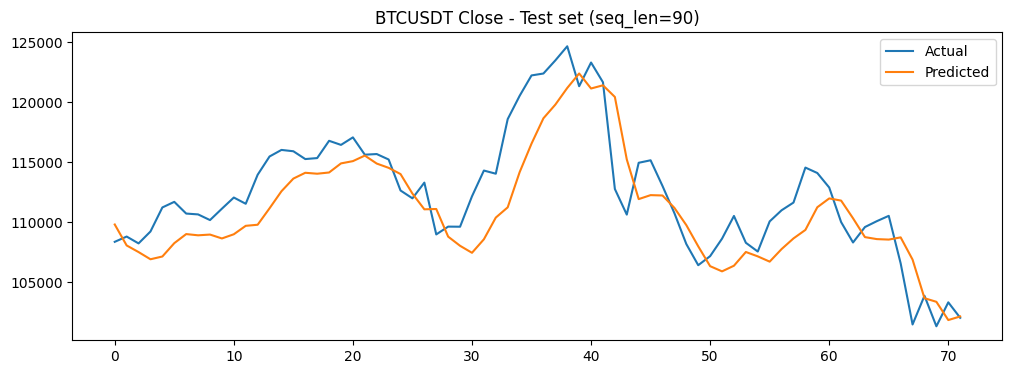

In [21]:
# Cell 15: Plot Actual vs Predicted (full test)
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))
plt.plot(y_true, label="Actual")
plt.plot(y_pred, label="Predicted")
plt.title(f"{sym} Close - Test set (seq_len={seq_len})")
plt.legend()
plt.show()


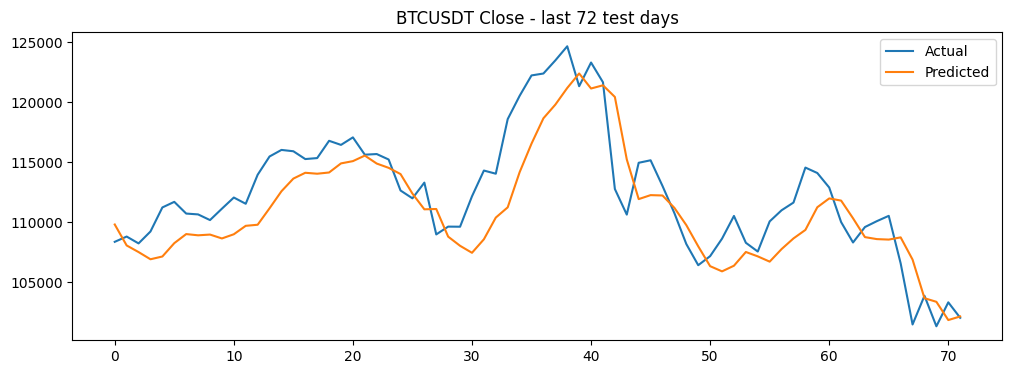

In [22]:
# Cell 16: Plot last 120 test days
import matplotlib.pyplot as plt

last_n = 120 if len(y_true) >= 120 else len(y_true)
plt.figure(figsize=(12,4))
plt.plot(y_true[-last_n:], label="Actual")
plt.plot(y_pred[-last_n:], label="Predicted")
plt.title(f"{sym} Close - last {last_n} test days")
plt.legend()
plt.show()
